# Systèmes, paradigmes et langages pour les Big Data - Project

*Authors: Elise Chin, Théo Quémener*

*Date: Sunday, March 6th*

__Flights Dataset Analysis.__
In this session, we will conduct a few analyses on a simplified flight fares dataset.  
In particular we will try to build cheapest routes from one point to another.

## Grading and Instructions
You must return your notebook before **Sunday March 6th 23:59 Paris time** by email to David : d.diebold@criteo.com.  
Grade will be composed of :
1. Timely return
2. Correctness (some questions may still leave you with some liberties)
3. Report formatting : While we allow you to return your project in a notebook format, you should think your report as being a classic text and image pdf report in which the code is in appendix. That means your notebook should be fully readable while hiding all the code cells.
4. Code Readability (factorized code, well-named variables, explain what you do when code becomes complicated, etc...)
5. Performance (this is not a race but we want you to think about performance issues when designing your solution (shuffles, etc...). Don't hesitate to annotate your notebook with any remarks about your solution.


## Install Spark Environment
Since we are not running on databricks, we will need to install Spark by ourselves, every time we run the session.  
We need to install Spark, as well as a Java Runtime Environment.  
Then we need to setup a few environment variables.  


In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!curl -O https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  287M  100  287M    0     0   197M      0  0:00:01  0:00:01 --:--:--  197M


In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf

conf = SparkConf().set('spark.ui.port', '4050')
sc = SparkContext(conf=conf)
spark = SparkSession.builder.master('local[*]').getOrCreate()

## Useful imports

In [40]:
import time
import numpy as np
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.sql.functions import col, lit
from pyspark.sql.types import ArrayType, StringType, IntegerType
from pyspark.sql import Window
from pyspark.sql.functions import udf

## Introduction
Aim of this notebook is to help you get comfortable with Spark Dataframe API while working on a flights dataset.  
This dataset contains some domestic flight prices for US country.  
We will call route a tuple identified by an origin airport and a destination airport.  
We will try to find-out what are the best options for a traveler, to go from some place to another.  
Here is a short description of the columns:
- ItinID & MktID: vaguely demonstrates the order in which tickets were ordered (lower ID #'s being ordered first)
- MktCoupons: the number of coupons in the market for that flight
- Quarter: 1, 2, 3, or 4, all of which are in 2018
- Origin: the city out of which the flight begins
- OriginWac: USA State/Territory World Area Code
- Dest: the city out of which the flight begins
- DestWac: USA State/Territory World Area Code
- Miles: the number of miles traveled
- ContiguousUSA: binary column -- (2) meaning flight is in the contiguous (48) USA states, and (1) meaning it is not (ie: Hawaii, Alaska, off-shore territories)
- NumTicketsOrdered: number of tickets that were purchased by the user
- Airline Company: the two-letter airline company code that the user used from start to finish (key codes below)
- PricePerTicket: ticket price

In [5]:
# download the dataset described above
from urllib import request
import zipfile

url = "https://www.dropbox.com/s/kda4h5su4z6go05/flights.zip?dl=1"
filehandle, _ = request.urlretrieve(url)
zip_file_object = zipfile.ZipFile(filehandle, 'r')
zip_file_object.extractall()

In [6]:
# This seond file contains a mapping with airports Code / Name / Latitude / Longitude
# It can help to get a better understanding of the airports you are dealing with.
# Source : https://www.partow.net/miscellaneous/airportdatabase/index.html#Downloads
url2 = "https://www.dropbox.com/s/xe2a3hgwlugos7a/GlobalAirportDatabase.txt?dl=1"
request.urlretrieve(url2, "airport_latlon.txt")

('airport_latlon.txt', <http.client.HTTPMessage at 0x7f41e82d0050>)

In [7]:
!ls

airport_latlon.txt	  spark-3.2.1-bin-hadoop3.2
Cleaned_2018_Flights.csv  spark-3.2.1-bin-hadoop3.2.tgz
sample_data




---


---



---



---



---


## Question 1 (1 point)
Display a few rows of the flights fare dataset, display it's schema, and count the amount of rows.  
You are likely to read this dataset a lots of times ; rewrite the dataset on the file system in an optimized way, to optimize further readings.  

## Answer: 

First we read the CSV file and store it as a pyspark dataframe. In the options when reading the CSV file we set `ìnferSchema=True` this spares us the task of defining the schema manually afterward.


After a quick exploration of the dataset using `.show()`, `.schema()` and `.count()` we saved the dataframe as a Parquet file.


Parquet is a columnar storage that allows us to reach a better efficiency. Additionnaly we stored our dataset in cache memory (as it fits) so that it will be faster to acces the data. 

We are now ready to answer the next questions.





### __1-1° CSV to pyspark dataframe.__
We first read the CSV file and store it as a pyspark Dataframe: `df_flights`

In [8]:
flights_path = 'Cleaned_2018_Flights.csv'
df_flights = spark.read.options(header=True).csv(flights_path)

In [9]:
df_flights.take(5)

[Row(_c0='0', ItinID='20181767585', MktID='2018176758501', MktCoupons='1', Quarter='1', Origin='PHL', OriginWac='23', Dest='LAX', DestWac='91', Miles='2402.0', ContiguousUSA='2', NumTicketsOrdered='1.0', AirlineCompany='AA', PricePerTicket='672.87'),
 Row(_c0='1', ItinID='20181767586', MktID='2018176758601', MktCoupons='1', Quarter='1', Origin='PHL', OriginWac='23', Dest='LAX', DestWac='91', Miles='2402.0', ContiguousUSA='2', NumTicketsOrdered='1.0', AirlineCompany='AA', PricePerTicket='367.68'),
 Row(_c0='2', ItinID='20181767587', MktID='2018176758701', MktCoupons='1', Quarter='1', Origin='PHL', OriginWac='23', Dest='LAX', DestWac='91', Miles='2402.0', ContiguousUSA='2', NumTicketsOrdered='1.0', AirlineCompany='AA', PricePerTicket='417.94'),
 Row(_c0='3', ItinID='20181767636', MktID='2018176763601', MktCoupons='1', Quarter='1', Origin='PHL', OriginWac='23', Dest='LAX', DestWac='91', Miles='2402.0', ContiguousUSA='2', NumTicketsOrdered='1.0', AirlineCompany='AA', PricePerTicket='247.1'

### __1-2° Displaying a few rows.__
We investigate the schema of the dataframe, we moreover find that constitues a record of $9534417$ flights.

In [ ]:
df_flights.show()

+---+-----------+-------------+----------+-------+------+---------+----+-------+------+-------------+-----------------+--------------+--------------+
|_c0|     ItinID|        MktID|MktCoupons|Quarter|Origin|OriginWac|Dest|DestWac| Miles|ContiguousUSA|NumTicketsOrdered|AirlineCompany|PricePerTicket|
+---+-----------+-------------+----------+-------+------+---------+----+-------+------+-------------+-----------------+--------------+--------------+
|  0|20181767585|2018176758501|         1|      1|   PHL|       23| LAX|     91|2402.0|            2|              1.0|            AA|        672.87|
|  1|20181767586|2018176758601|         1|      1|   PHL|       23| LAX|     91|2402.0|            2|              1.0|            AA|        367.68|
|  2|20181767587|2018176758701|         1|      1|   PHL|       23| LAX|     91|2402.0|            2|              1.0|            AA|        417.94|
|  3|20181767636|2018176763601|         1|      1|   PHL|       23| LAX|     91|2402.0|            2

In [ ]:
df_flights.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- ItinID: string (nullable = true)
 |-- MktID: string (nullable = true)
 |-- MktCoupons: string (nullable = true)
 |-- Quarter: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- OriginWac: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- DestWac: string (nullable = true)
 |-- Miles: string (nullable = true)
 |-- ContiguousUSA: string (nullable = true)
 |-- NumTicketsOrdered: string (nullable = true)
 |-- AirlineCompany: string (nullable = true)
 |-- PricePerTicket: string (nullable = true)



In [ ]:
n_rows = df_flights.count()
print(f'Amount of rows : {n_rows}')

Amount of rows : 9534417


### __1-3° Rewriting the dataset in an optimized way.__
We will use the parquet file format and store the dataset in cache so that it is easier to access: 

In [10]:
df_parquet_path = "Cleaned_2018_Flights.parquet"
spark.read.options(header=True).csv(flights_path, inferSchema=True).write.parquet(df_parquet_path)

In [11]:
df_flights = spark.read.options(header=True, inferSchema=True).parquet(df_parquet_path)

We cache the dataframe to avoid reloading them in subsequent computation.

In [12]:
df_flights.cache()

DataFrame[_c0: int, ItinID: bigint, MktID: bigint, MktCoupons: int, Quarter: int, Origin: string, OriginWac: int, Dest: string, DestWac: int, Miles: double, ContiguousUSA: int, NumTicketsOrdered: double, AirlineCompany: string, PricePerTicket: double]



---


---



---



---



---



## Question 2 (4 points)  
Find how many origin and destination airports are contained in the dataset.  
Show them on a US map to get a better intuition of the dataset. You can use shapely and geopandas to perform this task.  
Do we have all the lat/lon available ?

## Answer:    

- To count the number of origin airports we first select the column `Origin` of our dataset using the `df.select('col')` function. We then need to drop the redundants airports. To do so we use the `.distinct()` function. Finally we applied the `.count()`function to have the total number of distinct origin airports.

  For the destinations airports we follow the exact at the exception that we select the columns `Dest`. 
  We end up with $263$ origin airports and $260$ destination airports.

- To display the US airports on a map we first needed to extract the airport located in the US. 
  To do so we only selected latitudes and longitudes (from the dataset `airports_latlon.txt`) of the airports located in the united states of america using the function `.filter(airport_latlon['country']=='USA')`. 
  
  Then to map the airports to their latitudes and longitudes we simply noticed that the `IATA_code` in `airports_latlon` corresponds to the airports names in both `origin` and `destination`. We can then simply run an inner join between the two datasets on these two columns and select the columns that will be useful for the plot, namely: `(latitude, longitude)`.

### __2-1° Origin and destination :__
Using the command  ` df.select('col_of_interest').distinct().count()` we were able to find that there are $263$ origin airports and $260$ destination airports.

In [ ]:
# Count origin and destination airports
num_origin = df_flights.select('Origin').distinct().count()
num_destination = df_flights.select('Dest').distinct().count()

print(f'Number of origin airports: {num_origin}')
print(f'Number of destination airports: {num_destination}')

Number of origin airports: 263
Number of destination airports: 260




### __2-2° Mapping US Airports and their latitude and longitude__

Creating the dataframe `df_latlon` which will allow us to map the latitude and
the longitude to the associated airport.

In [ ]:
from pyspark.sql.types import Row

latlon_file = 'airport_latlon.txt'
sc = spark.sparkContext
lines = sc.textFile(latlon_file)
parts = lines.map(lambda l: l.split(":"))
airport_latlon = parts.map(lambda p: Row(ICAO_code=p[0], 
                                         IATA_code=p[1], 
                                         airport_name=p[2],
                                         city=p[3],
                                         country=p[4],
                                         lat_deg=int(p[5]),
                                         lat_min=int(p[6]),
                                         lat_sec=int(p[7]),
                                         lat_dir=p[8],
                                         lon_deg=p[9],
                                         lon_min=int(p[10]),
                                         lon_sec=int(p[11]),
                                         lon_dir=p[12],
                                         altitude=int(p[13]),
                                         lat_dec_deg=float(p[14]),
                                         lon_dec_deg=float(p[15])))
df_latlon = spark.createDataFrame(airport_latlon)

Displaying the first $20$ rows of  `df_latlon`.

In [ ]:
df_latlon.show()

+---------+---------+--------------------+--------------+----------------+-------+-------+-------+-------+-------+-------+-------+-------+--------+-----------+-----------+
|ICAO_code|IATA_code|        airport_name|          city|         country|lat_deg|lat_min|lat_sec|lat_dir|lon_deg|lon_min|lon_sec|lon_dir|altitude|lat_dec_deg|lon_dec_deg|
+---------+---------+--------------------+--------------+----------------+-------+-------+-------+-------+-------+-------+-------+-------+--------+-----------+-----------+
|     AYGA|      GKA|              GOROKA|        GOROKA|PAPUA NEW GUINEA|      6|      4|     54|      S|    145|     23|     30|      E|    1610|     -6.082|    145.392|
|     AYLA|      LAE|                 N/A|           LAE|PAPUA NEW GUINEA|      0|      0|      0|      U|    000|      0|      0|      U|       0|        0.0|        0.0|
|     AYMD|      MAG|              MADANG|        MADANG|PAPUA NEW GUINEA|      5|     12|     25|      S|    145|     47|     19|      E|  

We have a total of $270$ distinct aiports and $169$ are located within the USA.

In [ ]:
# dataframe with all the distinct airports :
df_airports = df_flights.select('Origin').union(df_flights.select('Dest')).distinct()
# counting the rows = number of distinct airports :
df_airports.count()

270

Using an inner join on `df_airports["Origin"] = df_latlon["IATA_code"]` we map USA airports and their GPS coordinates. 

In [ ]:
airports_latlon = df_airports.join(df_latlon, df_airports["Origin"] == df_latlon["IATA_code"], how="inner")
A = airports_latlon.select(['country','airport_name','lat_dec_deg','lon_dec_deg'])
US_airports = A.filter(A["country"]=="USA")

In [ ]:
US_airports.show()

+-------+--------------------+-----------+-----------+
|country|        airport_name|lat_dec_deg|lon_dec_deg|
+-------+--------------------+-----------+-----------+
|    USA|LOUIS ARMSTRONG N...|     29.993|    -90.258|
|    USA|SPOKANE INTERNATI...|      47.62|   -117.534|
|    USA|BURBANK GLENDALE ...|     34.201|   -118.359|
|    USA|JOHN WAYNE ARPT O...|     33.676|   -117.868|
|    USA|AUSTIN STRAUBEL I...|     44.485|    -88.129|
|    USA|GREAT FALLS INTER...|     47.482|   -111.371|
|    USA|GERALD R FORD INT...|     42.881|    -85.523|
|    USA|MYRTLE BEACH INTE...|      33.68|    -78.928|
|    USA|THEODORE FRANCIS ...|     41.724|    -71.428|
|    USA|METROPOLITAN OAKL...|     37.721|   -122.221|
|    USA|DANE CO RGNL TRUA...|      43.14|    -89.337|
|    USA|RONALD REAGAN WAS...|     38.852|    -77.037|
|    USA|NIAGARA FALLS INT...|     43.107|    -78.946|
|    USA|NORFOLK INTERNATI...|     36.894|    -76.201|
|    USA|OGDENSBURG INTERN...|     44.682|    -75.466|
|    USA|S

In [ ]:
US_airports.count()

169

In [ ]:
US_airports.printSchema()

root
 |-- country: string (nullable = true)
 |-- airport_name: string (nullable = true)
 |-- lat_dec_deg: double (nullable = true)
 |-- lon_dec_deg: double (nullable = true)



In [ ]:
!pip install geopandas

     |████████████████████████████████| 1.0 MB 31.3 MB/s 
     |████████████████████████████████| 16.7 MB 61.4 MB/s 
     |████████████████████████████████| 6.3 MB 46.1 MB/s 


In [ ]:
import geopandas

In [ ]:
lat_airports = np.array(US_airports.select('lat_dec_deg').collect())
lon_airports = np.array(US_airports.select('lon_dec_deg').collect())

Mapping the US airports on a map of the USA using geopandas. 

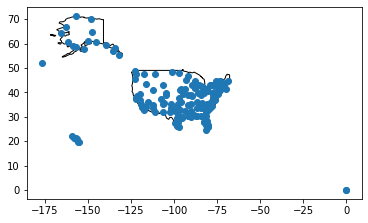

In [ ]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
usa = world[world.iso_a3 == "USA"]
usa.plot(color='white', edgecolor='black')
plt.scatter(x=lon_airports, y=lat_airports)



---


---



---



---



---


In the next two questions, we will want to get an understanding of ticket prices based on flight distance.  


## Question 3 (2 points)
To do that we first need to get and understanding of the flight distance distribution.  
We want to display an histogram of flight distances. To do this :  
- use numpy logspace function to create 10 distance buckets, base=1.05
- then use numpy digitize function inside a spark UDF to create the buckets.
- buckets should be displayed in the correct order, and displayed like this : [min;max]

## Answer : 

- First we need to get rid of the redundant couples `(origin, destination)`. 
  
  We could use a ` groupBy() ` but this a bit costly so instead we will use a ` Window.partitionBy()` and then average the price (for the next question).
  
  When trying to plot an histogram of the distances, should one try to get rid of another form of duplicates : ways and returns between two airports. That is, if there are flights `ABE -> ATL` and `AT -> ABE` should one try to identify these two? We tried to but eventually decided to ignore these cases and simply focus on the deduplication of the couples `(origin, destination)`. 

- Once this was and as the bins were already created we simply used the function `np.digitize()` to fill them. We observe that the histogram looks like a gaussian distribution (with a tiny irregularity to the right of its mean). 

### __3-1° Deduplication__

In [ ]:
df_flights.show()

+---+-----------+-------------+----------+-------+------+---------+----+-------+------+-------------+-----------------+--------------+--------------+
|_c0|     ItinID|        MktID|MktCoupons|Quarter|Origin|OriginWac|Dest|DestWac| Miles|ContiguousUSA|NumTicketsOrdered|AirlineCompany|PricePerTicket|
+---+-----------+-------------+----------+-------+------+---------+----+-------+------+-------------+-----------------+--------------+--------------+
|  0|20181767585|2018176758501|         1|      1|   PHL|       23| LAX|     91|2402.0|            2|              1.0|            AA|        672.87|
|  1|20181767586|2018176758601|         1|      1|   PHL|       23| LAX|     91|2402.0|            2|              1.0|            AA|        367.68|
|  2|20181767587|2018176758701|         1|      1|   PHL|       23| LAX|     91|2402.0|            2|              1.0|            AA|        417.94|
|  3|20181767636|2018176763601|         1|      1|   PHL|       23| LAX|     91|2402.0|            2

In [15]:
w = Window.partitionBy('Origin','Dest')

df_unique_flights = df_flights.withColumn('AvgPrice', F.avg('PricePerTicket').over(w))

In [16]:
df_unique_flights = df_unique_flights.select('Origin','Dest','Miles','AvgPrice')

In [17]:
df_unique_flights = df_unique_flights.dropDuplicates(['Origin','Dest']).withColumn('AvgPrice', F.round('AvgPrice', 2))

In [18]:
df_unique_flights.show(5)

+------+----+------+--------+
|Origin|Dest| Miles|AvgPrice|
+------+----+------+--------+
|   ABE| ATL| 692.0|  243.15|
|   ABE| FLL|1041.0|  100.49|
|   ABI| DFW| 158.0|  613.88|
|   ABQ| AGS|1412.0|  354.44|
|   ABQ| AUS| 619.0|  140.13|
+------+----+------+--------+
only showing top 5 rows



In [ ]:
df_unique_flights.count()

8471

#### __Further attempt to deduplicate__

In [ ]:
from pyspark.sql.functions import col

In [ ]:
df_as1 = df_unique_flights.alias("df_as1")
df_as2 = df_unique_flights.alias("df_as2")

In [ ]:
df_return_flights = df_as1.join(df_as2, (col("df_as1.Origin") == col("df_as2.Dest")) & (col("df_as1.Dest") == col("df_as2.Origin")), "inner")\
                          .withColumn("New_AvgPrice", (col("df_as1.AvgPrice") + col("df_as2.AvgPrice")) / 2)

In [ ]:
df_return_flights.show()

+------+----+------+--------+------+----+------+--------+------------------+
|Origin|Dest| Miles|AvgPrice|Origin|Dest| Miles|AvgPrice|      New_AvgPrice|
+------+----+------+--------+------+----+------+--------+------------------+
|   ABE| ATL| 692.0|  243.15|   ATL| ABE| 692.0|  243.14|243.14499999999998|
|   ABE| FLL|1041.0|  100.49|   FLL| ABE|1041.0|   98.39|             99.44|
|   ABQ| AGS|1412.0|  354.44|   AGS| ABQ|1412.0|  349.34|            351.89|
|   ABQ| AUS| 619.0|  140.13|   AUS| ABQ| 619.0|  146.67|143.39999999999998|
|   ABQ| BHM|1138.0|  251.87|   BHM| ABQ|1138.0|  229.78|           240.825|
|   ABQ| BOS|1974.0|   197.0|   BOS| ABQ|1974.0|  252.75|           224.875|
|   ABQ| BTV|1881.0|  275.35|   BTV| ABQ|1881.0|  294.29|284.82000000000005|
|   ABQ| BUR| 672.0|  165.81|   BUR| ABQ| 672.0|  186.83|            176.32|
|   ABQ| BWI|1670.0|  288.32|   BWI| ABQ|1670.0|  286.41|           287.365|
|   ABQ| CHS|1528.0|  328.31|   CHS| ABQ|1528.0|  317.59|            322.95|

In [ ]:
df_return_flights.count()

7872

In [ ]:
df_unique_flights.count()

8471

There are 7872/2 = 3936 one-ways also having returns, so we count the same distance twice, and we have 8471-7872 = 599  one-ways. In total there are 3936+599=4535 unique distances.

With `df_return_flights` being not null, we know that in `df_unique_flights` we count a distance between two airports twice (e.g. ABE-ATL and ATL-ABE). We have exactly 3936 pairs of airports that are counted twice, but we don't know exactly which pairs. We tried to find a solution to delete those duplicates, but in vain. So in the following, we will consider routes between an airport A and an airport B as directed flights, and so if the round trip exists in the initial dataset, then the distance between A and B will be counted twice.

### __3-2° Creation of the bins__

In [ ]:
min_miles_distance = df_unique_flights.agg({'Miles': 'min'}).collect()[0]['min(Miles)']
max_miles_distance = df_unique_flights.agg({'Miles': 'max'}).collect()[0]['max(Miles)']

bins = np.logspace(np.log10(min_miles_distance), np.log10(max_miles_distance), num=10, dtype='int32')

In [ ]:
print(f'The minimum distance is {min_miles_distance} while the maximum is {max_miles_distance}')

The minimum distance is 11.0 while the maximum is 5095.0


In [ ]:
bins

array([  10,   21,   43,   85,  168,  332,  658, 1302, 2576, 5095],
      dtype=int32)

### __3-3° Filling the buckets__

In [ ]:
def assign_bucket(miles):
    return int(np.digitize(miles, bins, right=True))

In [ ]:
assign_bucket_udf = udf(assign_bucket, IntegerType())

In [ ]:
df_unique_flights = df_unique_flights.withColumn("Num_miles_bucket", assign_bucket_udf("Miles"))

In [ ]:
miles_bucket_count = df_unique_flights.groupBy("Num_miles_bucket").count().toPandas()

In [ ]:
miles_bucket_count.set_index("Num_miles_bucket", inplace=True)

In [ ]:
miles_bucket_count.sort_index(inplace=True)

In [ ]:
ranges = []
for i in range(len(bins)-1):
    ranges.append(f"]{bins[i]}-{bins[i+1]}]")
ranges

[']10-21]',
 ']21-43]',
 ']43-85]',
 ']85-168]',
 ']168-332]',
 ']332-658]',
 ']658-1302]',
 ']1302-2576]',
 ']2576-5095]']

In [ ]:
miles_bucket_count["Bucket_range"] = ranges

In [ ]:
miles_bucket_count

,count,Bucket_range
Num_miles_bucket,,
1,2,]10-21]
2,6,]21-43]
3,19,]43-85]
4,106,]85-168]
5,518,]168-332]
6,1571,]332-658]
7,3308,]658-1302]
8,2603,]1302-2576]
9,338,]2576-5095]


<BarContainer object of 9 artists>

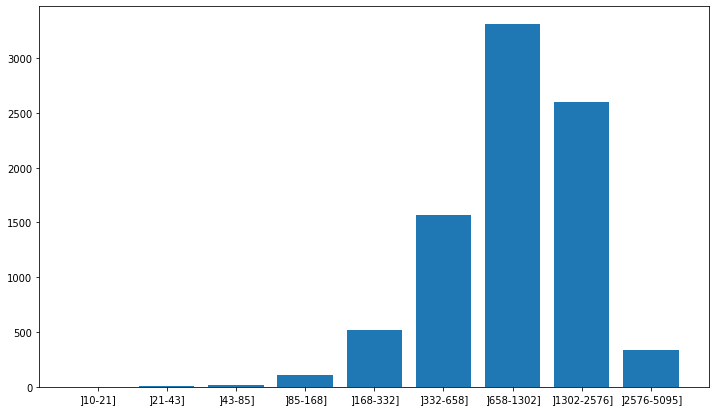

In [ ]:
plt.figure(figsize=(12, 7))
plt.bar(miles_bucket_count["Bucket_range"], miles_bucket_count["count"])



---


---



---



---



---

## Question 4 (3 points)
Display the average flight fares for each distance bucket.  
Graph should also contain the confidence intervals.  
Buckets should be displayed in the correct order, and displayed like this : $[min;max]$  
Interpret the results.  

## Answer : 

- To compute the average flight for each bucket we simply exploit the colmun `Num_miles_bucket` which assigns to each flight the bucket it belongs to (based on the distance covered by the flight).
  All is left to do is to use a `groupBy`on the column `Num_miles_bucket` in combination with an aggregation of type average on the ` Price`. We detailed our study by computing the intra bucket standard deviation and the cardinality of each bucket.
- We finally find: 

Num_miles_bucket | mean | std | N | Bucket_range
-------------------|------------------|---|---|---
1 |	204.105000 	|11.702617 	|2 	|]10-21] 	
2 |	124.895000 	|20.101554 	|6 |	]21-43] 	
3 |	182.598947 	|126.703078 |	19| 	]43-85] 	
4 |	216.511604 |	109.372166 |106| 	]85-168] 	
5 |	202.772819 |	72.103439 	|518| 	]168-332] 	
6 |	183.790936 |	67.266215 	|1571| 	]332-658] 	
7 |	203.024030 |	75.620382 	|3308 |	]658-1302] 	
8 |	268.221275 |	77.495474 	|2603| 	]1302-2576] 	
9 |	418.740769 |	124.011352 	|338 |	]2576-5095] 	

  We can observe that the mean remains stable within the seven first bucket but then grows significantly with the distance for the two last buckets. As a result, in terms of mean, the price is not obviously correlated to the distance if the flights covers less than $ 1302$ miles. For long haul flights the prices are significantly higher. 



In [ ]:
df_unique_flights.show(5)

+------+----+------+--------+----------------+
|Origin|Dest| Miles|AvgPrice|Num_miles_bucket|
+------+----+------+--------+----------------+
|   ABE| ATL| 692.0|  243.15|               7|
|   ABE| FLL|1041.0|  100.49|               7|
|   ABI| DFW| 158.0|  613.88|               4|
|   ABQ| AGS|1412.0|  354.44|               8|
|   ABQ| AUS| 619.0|  140.13|               6|
+------+----+------+--------+----------------+
only showing top 5 rows



### __Average flight fares for each distance bucket__

In [ ]:
df_prices = df_unique_flights.groupby("Num_miles_bucket").agg(F.avg('AvgPrice').alias('mean'),\
                                              F.stddev('AvgPrice').alias('std'),\
                                              F.count('AvgPrice').alias('N')).toPandas()

In [ ]:
df_prices

,Num_miles_bucket,mean,std,N
0,1,204.105000,11.702617,2
1,6,183.790936,67.266215,1571
2,3,182.598947,126.703078,19
3,5,202.772819,72.103439,518
4,9,418.740769,124.011352,338
5,4,216.511604,109.372166,106
6,8,268.221275,77.495474,2603
7,7,203.024030,75.620382,3308
8,2,124.895000,20.101554,6


In [ ]:
df_prices.set_index("Num_miles_bucket", inplace=True)
df_prices.sort_index(inplace=True)

In [ ]:
df_prices["Bucket_range"] = ranges

In [ ]:
df_prices["IC"] = 1.96 * df_prices["std"] / df_prices["N"]

In [ ]:
df_prices

,mean,std,N,Bucket_range,IC
Num_miles_bucket,,,,,
1,204.105000,11.702617,2,]10-21],11.468565
2,124.895000,20.101554,6,]21-43],6.566508
3,182.598947,126.703078,19,]43-85],13.070423
4,216.511604,109.372166,106,]85-168],2.022353
5,202.772819,72.103439,518,]168-332],0.272824
6,183.790936,67.266215,1571,]332-658],0.083922
7,203.024030,75.620382,3308,]658-1302],0.044805
8,268.221275,77.495474,2603,]1302-2576],0.058352
9,418.740769,124.011352,338,]2576-5095],0.719119


<BarContainer object of 9 artists>

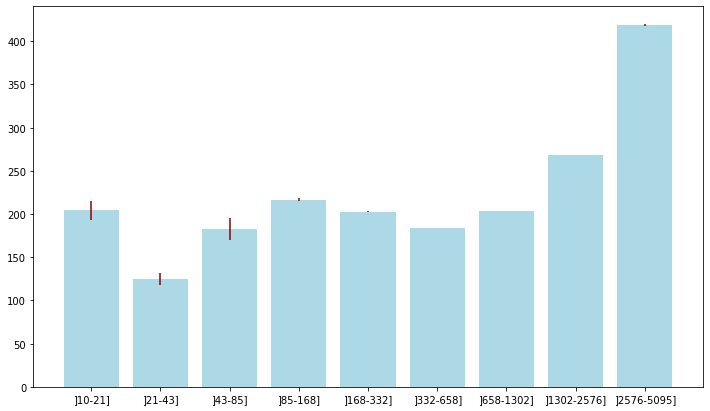

In [ ]:
plt.figure(figsize=(12, 7))
plt.bar(df_prices["Bucket_range"], df_prices["mean"], yerr=df_prices["IC"], color='lightblue', ecolor='darkred')




---


---



---



---



---

## Question 5 (4 points)
For the remainder of the notebook, we will only take care of the average price of each route.  
Our goal is to find cheap combinations of flights to travel from one place to another.  
First, we want to build a dataframe named 'cheapest_routes_df' containing the cheapest price to go from one place to another, with one or zero waypoint. Dataframe should look like this (Waypoints column can be empty) :  

Origin  | Destination | Waypoints | TotalPrice
-------------------|------------------|---|---
ACY       | MOB | ATL | 323.0

  
Is it interesting to consider waypoints to go from one place to another ?  

## Answer:

The goal of this question is question is to build a dataframe named 'cheapest_routes_df' containing the cheapest price to go from one place to another, with at most one waypoint. To do so we followed the following steps:

- Select the relevant columns and compute the average price for each route with no waypoint: this will be our dataframe `df_origin_dest` it is structured as follows  

Origin  | Destination | AvgPrice
----------|---------|------------------
PHIL | MCO | 188.23


There are now two approaches that we explored to build $routes_1$.

- The first consists in creating an intermediary dataset `df_origin_waypoint_dest` with the routes having exactly one waypoint (including new routes). To consider the union of the two datasets `df_origin_dest`and `df_origin_dest`and then run a `groupBy('Origin','Dest').agg(F.round(F.min('Price'), 2)))`. 

  As explained below, following this strategy we have a readibility issue (due to the use of groupBy()) which can be adressed using a join. 

- A way to circumvent the use of this join in the previous approach is to make use of the `Window.partitionBy()` function. We proceed a time execution comparison to show the advantage of using this approach compared to a `groupBy`and `join` approach.

###  __5-1° Compute average price for each route__

Extracting the 3 three columns `Origin', 'Dest', 'PricePerTicket'` from the orginal dataset `df_flights` we build the dataframe `df_origin_dest`. 
We first use it to compute the average price for the given routes, that is the average prices for the flights corresponding to the couples `(origin,destination)`.

In [19]:
# dataframe creation & computation of the average price of a route : 
df_origin_dest = df_flights.select('Origin', 'Dest', 'PricePerTicket')\
                                    .groupBy('Origin', 'Dest')\
                                    .agg(F.round(F.avg('PricePerTicket'), 2).alias('AvgPrice'))

In [20]:
df_origin_dest.show(2)

+------+----+--------+
|Origin|Dest|AvgPrice|
+------+----+--------+
|   PHL| MCO|  188.23|
|   PBI| DCA|  227.52|
+------+----+--------+
only showing top 2 rows



### __5-2 ° Create dataframe with exactly 1 waypoint__

First, we create two dataframes from `df_origin_dest` where we rename `dest` into `waypoint` for the first one and `origin` to `waypoint` for the second one. 

In [21]:
# Origin ---> Waypoint : 
df_origin_waypoint = df_origin_dest.withColumnRenamed("Dest", "Waypoint")\
                                   .withColumnRenamed('AvgPrice', 'OW_AvgPrice')

# Waypoint ---> Origin :
df_waypoint_dest = df_origin_dest.withColumnRenamed("Origin", "Waypoint")\
                                 .withColumnRenamed('AvgPrice', 'WD_AvgPrice')

In [ ]:
df_origin_waypoint.show(5)
df_waypoint_dest.show(5)

+------+--------+-----------+
|Origin|Waypoint|OW_AvgPrice|
+------+--------+-----------+
|   PHL|     MCO|     188.23|
|   PBI|     DCA|     227.52|
|   ORD|     PDX|     248.01|
|   SNA|     PHX|     181.32|
|   MCI|     IAH|     231.07|
+------+--------+-----------+
only showing top 5 rows

+--------+----+-----------+
|Waypoint|Dest|WD_AvgPrice|
+--------+----+-----------+
|     PHL| MCO|     188.23|
|     PBI| DCA|     227.52|
|     ORD| PDX|     248.01|
|     SNA| PHX|     181.32|
|     MCI| IAH|     231.07|
+--------+----+-----------+
only showing top 5 rows



We then join the two dataframes on `waypoint`, create a new column `Price` corresponding to the sum of the average price per ticket to go from `origin` to `waypoint`, and from `waypoint` to `dest`.

In [22]:
# With one waypoint
df_origin_waypoint_dest = df_origin_waypoint.join(df_waypoint_dest, on="Waypoint")\
                                            .withColumn("SumPrice", F.round(col("OW_AvgPrice")+col("WD_AvgPrice"), 2))\
                                            .select("Origin", "Waypoint", "Dest", "SumPrice")\
                                            .withColumnRenamed('SumPrice','Price')

In [ ]:
df_origin_waypoint_dest.show(5)

+------+--------+----+------+
|Origin|Waypoint|Dest| Price|
+------+--------+----+------+
|   MFE|     PHL| MCO|511.34|
|   SDF|     PHL| MCO|327.23|
|   SRQ|     PHL| MCO|302.84|
|   RIC|     PHL| MCO|683.73|
|   STT|     PHL| MCO|693.37|
+------+--------+----+------+
only showing top 5 rows



### __5-3° Create dataframe with no waypoint__

We add a new null column `waypoint` in `df_origin_dest`.
No need to create a new dataframe, we can directly modify `df_origin_dest`.

In [ ]:
df_origin_dest.show(1)

+------+----+--------+
|Origin|Dest|AvgPrice|
+------+----+--------+
|   PHL| MCO|  188.23|
+------+----+--------+
only showing top 1 row



In [23]:
# Rename column Price
df_origin_dest = df_origin_dest.withColumnRenamed("AvgPrice", "Price") 

# Add null waypoint column
df_origin_dest = df_origin_dest.withColumn("Waypoint", lit(None)) 

# Reorder columns for the union
L = df_origin_waypoint_dest.columns
df_origin_dest = df_origin_dest.select(L)

# Show
df_origin_dest.show(5)

+------+--------+----+------+
|Origin|Waypoint|Dest| Price|
+------+--------+----+------+
|   PHL|    null| MCO|188.23|
|   PBI|    null| DCA|227.52|
|   ORD|    null| PDX|248.01|
|   SNA|    null| PHX|181.32|
|   MCI|    null| IAH|231.07|
+------+--------+----+------+
only showing top 5 rows



### __5-4° Creation of $Routes_1$__

We first consider the union of the two dataframes `df_origin_dest` and `df_origin_waypoint_dest` into the dataframe `df_origin_at_most_one_waypoint_des`. We then apply `groupBy` on the coulples `(origin,destination)` and an aggregation of type `min` on the column `Price`.

In [24]:
# Union of the two datasets: 
df_origin_at_most_one_waypoint_dest = df_origin_waypoint_dest.union(df_origin_dest)

In [ ]:
print('There are {} rows in the dataframe df_origin_at_most_one_waypoint_dest'.format(df_origin_at_most_one_waypoint_dest.count()))
df_origin_at_most_one_waypoint_dest.show(5)

There are 635152 rows in the dataframe df_origin_at_most_one_waypoint_dest
+------+--------+----+------+
|Origin|Waypoint|Dest| Price|
+------+--------+----+------+
|   MFE|     PHL| MCO|511.34|
|   SDF|     PHL| MCO|327.23|
|   SRQ|     PHL| MCO|302.84|
|   RIC|     PHL| MCO|683.73|
|   STT|     PHL| MCO|693.37|
+------+--------+----+------+
only showing top 5 rows



Compute minimum price to go from one place to another with at most one waypoint (here it is the min between the price with exactly one waypoint and without).

#### GroupBy + Join

In [ ]:
# grouping and aggregating : 
start_time = time.time()
df_min = df_origin_at_most_one_waypoint_dest.groupBy(['Origin','Dest'])\
                                            .agg(F.round(F.min('Price'), 2))\
                                            .withColumnRenamed('round(min(Price), 2)','Price')

exec_time = time.time() - start_time                                            

We now have a readability issue : we only see the couples `(orgin,destination)` and the asociated prices without knowing if there is a waypoint or not. 
To solve this issue we will use the proper join on 

In [ ]:
# Rename columns
start_time = time.time()
df_min = df_min.toDF('Origin2','Dest2','MinPrice')
exec_time += time.time() - start_time  

print(df_min.count())
df_min.show(5)

48940
+-------+-----+--------+
|Origin2|Dest2|MinPrice|
+-------+-----+--------+
|    DSM|  MCO|  159.48|
|    MEM|  LIH|   427.0|
|    PSP|  GSP|  325.03|
|    SLC|  GSP|  161.33|
|    AMA|  MEM|  294.67|
+-------+-----+--------+
only showing top 5 rows



Join `df_min` and `df_origin_at_most_one_waypoint_dest` to get `routes_1`, dataframe that contains cheapest routes with at most 1 waypoint.


In [ ]:
start_time = time.time()
cond = [df_min['Origin2']==df_origin_at_most_one_waypoint_dest['Origin'],\
        df_min['Dest2']==df_origin_at_most_one_waypoint_dest['Dest'],\
        df_min['MinPrice']==df_origin_at_most_one_waypoint_dest['Price']]
exec_time += time.time() - start_time  

In [ ]:
# reste à trouver le bon type de join :
start_time = time.time()

routes_1 = df_origin_at_most_one_waypoint_dest.join(df_min, cond, 'inner').select('Origin','Waypoint','Dest','MinPrice')

exec_time += time.time() - start_time  

In [ ]:
print(f"With groupBy+join: {exec_time} seconds")

With groupBy+join: 0.22961211204528809 seconds


In [ ]:
routes_1.show()

+------+--------+----+--------+
|Origin|Waypoint|Dest|MinPrice|
+------+--------+----+--------+
|   SHD|     ORD| PDX|   499.0|
|   CVG|     MYR| CKB|   152.5|
|   CKB|     MYR| CKB|   146.6|
|   TLH|     LEX| VPS|  382.31|
|   RKS|     DEN| ABQ|   357.8|
|   BUF|     BWI| MFE|  354.17|
|   MRY|     LAS| CMH|   281.0|
|   ATL|     COS| SAN|  305.22|
|   CHO|     ATL| SRQ|  453.27|
|   DAY|     ATL| BZN|  629.42|
|   FNT|     DEN| PSP|  334.88|
|   FAT|     DEN| PSP|  303.95|
|   USA|     SFB| ABE|  198.88|
|   SJU|     SFB| ABE|  220.91|
|   ATL|     FLL| BLV|  267.28|
|   OKC|     LAX| ASE|  401.18|
|   GRR|     SFB| FWA|   229.8|
|   CHA|     PIE| DSM|  201.27|
|   RDU|     CVG| SRQ|  170.06|
|   RFD|     LAS| CHS|  380.32|
+------+--------+----+--------+
only showing top 20 rows



In [ ]:
routes_1.count()

48941

#### window.partitionBy

In [ ]:
w = Window.partitionBy('Origin','Dest')

start_time = time.time()
routes_1 = df_origin_at_most_one_waypoint_dest.withColumn('FinalPrice', F.min('Price').over(w))\
                                              .where(F.col('Price') == F.col('FinalPrice'))\
                                              .drop('Price')
exec_time = time.time() - start_time
print(f"With partitionBy: {exec_time} seconds")

With partitionBy: 0.043199777603149414 seconds


In [ ]:
routes_1.show(5)

+------+--------+----+----------+
|Origin|Waypoint|Dest|FinalPrice|
+------+--------+----+----------+
|   ABE|     ATL| AGS|    471.39|
|   ABE|     FLL| AMA|    385.39|
|   ABE|    null| ATL|    243.15|
|   ABE|     PGD| ATW|    226.23|
|   ABE|     PIE| AUS|    198.22|
+------+--------+----+----------+
only showing top 5 rows



In [ ]:
routes_1.count()

48941

Conclusion: we gain a x5 speepdup with `partitionBy` instead of `groupBy+join`.



---


---



---



---



---

## Question 6 (6 points)
Now we want to create the dataframe with cheap combinations of flights from one place to another, but there is no longer any limitation on the amount of waypoints.  
Let $Routes_{k}$ designate the dataframe that contains cheapest routes for at most $k$ waypoints.  
This dataframe contains a column named 'Waypoints', containing an array of waypoints.  
Then:  
- Define a function that computes $Routes_{k+1}$ from $Routes_{k}$ and $Routes_{0}$.  
- Test it on a simple dataset made of three rows, built with $spark.sparkContext.parallelize$.  
- Use it iteratively to build what we want.  
- At each step, measure the amount of routes with k waypoints.  
- What is the stopping criterion ?  
- Measure the execution time of each step.  
- What if we want to execute the iterations up to $k=15$ ?  
- Explain what happens, and find a solution to approximately have the same execution time at each iteration.  
- Analyze the results obtained for $Routes_{maxK}$
- Analyze the euros spared, putting them in front of the extra miles traveled.

### 6-1° Define a function that computes $Routes_{k+1}$ from $Routes_k$ and  $Routes_0$

`routes_k` will have the following columns in this particular order:
- `Origin`: the origin airport
- `Waypoints`: an array of waypoints to go from the origin to the destination
- `Dest`: the destination airport
- `MinPrice`: the minimum price associated to this route
- `Num_waypoints`: the number of waypoints of the route, which the length of the array of waypoints. We add this column to compute the amount of routes with `k` waypoints by filtering on it. 

The function that computes $routes_{k+1}$ from $routes_k$ and $routes_0$ is called `compute_routes_k_plus_one(routes_k, routes_0)` and can be decomposed into three steps (similarly to the reasoning in question 5-2°). We write a function for each step:
1. `get_routes_with_one_more_wp` returns a dataframe containing one more waypoint than the array of waypoints in `routes_k`. To do that, we first create two dataframes from `routes_k` and `routes_0` by renaming columns, in order to join them on the new waypoint, which corresponds to the destination in `routes_k` or the origin in `routes_0`. We execute a join on those two dataframes, create a new column `MinPrice` which is the sum of the prices of `routes_k` and `routes_0`, and updates the column `Num_waypoints` by adding 1 to the number of waypoints in `routes_k`. The new waypoint (Destination in `routes_k`) needs to be added to the list of waypoints. We use an UDF which appends an element to a list to do this task. The newly created dataframe with one more waypoint (might) contains (Origin, Destination) pairs that do not exist in the first place (in the original dataset of flights). To keep the same pairs, we lastly execute a *leftsemi* join with the new dataframe and `routes_0` on `Origin` and `Destination`. With this join type, we keep the columns of the left dataframe (so the newly created one) but with the pairs of airports of the original data, `routes_0` here.

2. `get_routes_with_at_most_k1_wp(df_k_plus_one_waypoints, routes_k)` returns a dataframe that contains routes with at most $k+1$ waypoints. An `unionByName()` between `df_k_plus_one_waypoints` (dataframe with one more waypoint computed in the previous step) and `routes_k` (dataframe with at most k waypoints) simply do the job.

3. `compute_min_price(df_at_most_k_plus_one_waypoints)` computes the new minimum price between routes with at most $k$ waypoints and routes with at most $k+1$ waypoints.

In [41]:
def add_to_list(L, x):
    L.append(x)
    return L

add_to_list_udf = udf(add_to_list, ArrayType(StringType()))

In [26]:
def get_routes_with_one_more_wp(routes_k, routes_0):
    
    # Create two dataframes for following join on new waypoint
    df_origin_waypoint = routes_k.toDF('Origin', 'Waypoints', 'NewWaypoint', 'OW_MinPrice', 'OW_Num_waypoints')
    df_waypoint_dest = routes_0.toDF('NewWaypoint', 'WD_Waypoints', 'Dest', 'WD_MinPrice', 'WD_Num_waypoints')

    # Join on new waypoint (Waypoints (list of strings), NewWaypoint (string))
    df_k_plus_one_waypoints = df_origin_waypoint.join(df_waypoint_dest, on="NewWaypoint")\
                                                       .withColumn("MinPrice", col("OW_MinPrice")+col("WD_MinPrice"))\
                                                       .withColumn("Num_waypoints", col("OW_Num_waypoints")+1)\
                                                       .select("Origin", "Waypoints", "NewWaypoint", "Dest", "MinPrice", "Num_waypoints")

    # Add new waypoint to list of waypoints
    df_k_plus_one_waypoints = df_k_plus_one_waypoints.withColumn("k1_waypoints", add_to_list_udf("Waypoints", col("NewWaypoint")))

    # Clean
    df_k_plus_one_waypoints = df_k_plus_one_waypoints.drop("NewWaypoint", "Waypoints")\
                                                     .withColumnRenamed("k1_waypoints", "Waypoints")

    # In the new dataframe, keep the same (Origin, Destination) pairs as in routes_0 
    df_k_plus_one_waypoints = df_k_plus_one_waypoints.join(routes_0,\
                                                         on=[df_k_plus_one_waypoints.Origin == routes_0.Origin, df_k_plus_one_waypoints.Dest == routes_0.Dest],\
                                                         how="leftsemi")

    return df_k_plus_one_waypoints

def get_routes_with_at_most_k1_wp(df_k_plus_one_waypoints, routes_k):
    df_at_most_k_plus_one_waypoints = df_k_plus_one_waypoints.unionByName(routes_k)
    return df_at_most_k_plus_one_waypoints

def compute_min_price(df_at_most_k_plus_one_waypoints):
    w = Window.partitionBy('Origin','Dest')
    routes_k1 = df_at_most_k_plus_one_waypoints.withColumn('NewMinPrice', F.round(F.min('MinPrice').over(w), 2))\
                                              .where(F.col('NewMinPrice') == F.col('MinPrice'))\
                                              .drop('MinPrice')\
                                              .withColumnRenamed('NewMinPrice', 'MinPrice')
    routes_k1 = routes_k1.select('Origin', 'Waypoints', 'Dest', 'MinPrice', 'Num_waypoints')

    return routes_k1

In [27]:
def compute_routes_k_plus_one(routes_k, routes_0):
    
    # 1. Get routes with one more waypoint
    df_k_plus_one_waypoints = get_routes_with_one_more_wp(routes_k, routes_0)

    # 2. Get routes with at most k+1 waypoints (union)
    df_at_most_k_plus_one_waypoints = get_routes_with_at_most_k1_wp(df_k_plus_one_waypoints, routes_k)

    # 3. Minimum price between routes with at most k waypoints and routes with at most k+1 waypoints (min)
    routes_k1 = compute_min_price(df_at_most_k_plus_one_waypoints)

    return routes_k1

### 6-2° Test it on a simple dataset made of three rows, built with `spark.sparkContext.parallelize`.

In [35]:
def create_df(data, columns, verbose=True):
    rdd = spark.sparkContext.parallelize(data)
    df = spark.createDataFrame(rdd, schema = columns)
    return df

In [37]:
columns_k = ["Origin", "Waypoints", "Dest", "MinPrice", "Num_waypoints"]
columns_0 = ["Origin", "Dest", "MinPrice", "Num_waypoints"]

# Create an example routes_0
data_routes_0 = [("D", "X", 10, 0),\
            ("D", "Y", 30, 0),\
            ("H", "Z", 40, 0),\
            ("E", "F", 40, 0)]
ex_routes_0 = create_df(data_routes_0, columns_0)
ex_routes_0 = ex_routes_0.withColumn("Waypoints", F.expr('array()')).select("Origin", "Waypoints", "Dest", "MinPrice", "Num_waypoints")

# Create an example routes_k
data_routes_k = [("A", ["B","C"], "D", 100, 2),\
            ("E", ["F","G"], "H", 70, 2),\
            ("I", ["J"], "L", 30, 1),\
            ("A", ["B","C"], "E", 100, 2)]
ex_routes_k = create_df(data_routes_k, columns_k)

In [42]:
ex_routes_k1 = compute_routes_k_plus_one(ex_routes_k, ex_routes_0)

In [43]:
ex_routes_0.show()
ex_routes_k.show()
ex_routes_k1.show()

+------+---------+----+--------+-------------+
|Origin|Waypoints|Dest|MinPrice|Num_waypoints|
+------+---------+----+--------+-------------+
|     D|       []|   X|      10|            0|
|     D|       []|   Y|      30|            0|
|     H|       []|   Z|      40|            0|
|     E|       []|   F|      40|            0|
+------+---------+----+--------+-------------+

+------+---------+----+--------+-------------+
|Origin|Waypoints|Dest|MinPrice|Num_waypoints|
+------+---------+----+--------+-------------+
|     A|   [B, C]|   D|     100|            2|
|     E|   [F, G]|   H|      70|            2|
|     I|      [J]|   L|      30|            1|
|     A|   [B, C]|   E|     100|            2|
+------+---------+----+--------+-------------+

+------+---------+----+--------+-------------+
|Origin|Waypoints|Dest|MinPrice|Num_waypoints|
+------+---------+----+--------+-------------+
|     A|   [B, C]|   D|     100|            2|
|     A|   [B, C]|   E|     100|            2|
|     E|   

### 6-3° Apply on the flights dataset

We want to build `routes_k` iteratively for k from 0 until a stopping criterion is satisfied. We logically choose to stop the process when adding a new waypoint does not minimize the price. In other words, if at step $k+1$, the number of routes with $k+1$ waypoints is 0, meaning that no routes with $k+1$ waypoints leads to the cheapest route given an origin and destination airport, then we stop. 

So at each step, we measure the amount of routes with $k$ waypoints, through a function `count_routes_with_k_waypoints(df, k)` which filters rows on the `Num_waypoints` column, and counts the number of remaining rows.  

To construct `routes_0`, we reuse `df_origin_dest`, the dataframe with no waypoints. To respect our predefined schema, we add a column `Waypoints` with empty arrays and `Num_waypoints` filled with 0s. We rename the column `Price` to `MinPrice`. 

__Creation of `routes_0`__

In [ ]:
df_origin_dest.columns

['Origin', 'Waypoint', 'Dest', 'Price']

In [ ]:
routes_0 = df_origin_dest.withColumn("Waypoints", F.expr('array()'))\
                         .withColumn("Num_waypoints", lit(0))\
                         .drop("Waypoint")\
                         .withColumnRenamed("Price", "MinPrice")\
                         .select("Origin", "Waypoints", "Dest", "MinPrice", "Num_waypoints")

routes_0.show(2)

+------+---------+----+--------+-------------+
|Origin|Waypoints|Dest|MinPrice|Num_waypoints|
+------+---------+----+--------+-------------+
|   PHL|       []| MCO|  188.23|            0|
|   PBI|       []| DCA|  227.52|            0|
+------+---------+----+--------+-------------+
only showing top 2 rows



__Function to compute the number of routes with $k$ waypoints__

In [ ]:
def count_routes_with_k_waypoints(df, k):
    num_routes = df.filter(df.Num_waypoints == k).count()
    return num_routes

__Test on flights dataset__

We compute `routes_k` for $k \in [0, 5]$

In [ ]:
total_num_routes_0 = routes_0.count()

In [ ]:
list_routes = [routes_0]
list_total_num_routes = [total_num_routes_0]
list_num_routes_with_k = [total_num_routes_0]

In [ ]:
total_num_routes_0

In [ ]:
for k in range(5):
    start_time = time.time()
    routes_k1 = compute_routes_k_plus_one(list_routes[k], routes_0)
    list_routes.append(routes_k1)
    exec_time = time.time() - start_time
    print(f"[routes_{k+1}] {exec_time} seconds")

    total_num_routes = routes_k1.count()
    num_routes_with_k = count_routes_with_k_waypoints(routes_k1, k+1)
    print(f"\t Number of routes with {k+1} waypoints: {num_routes_with_k}/{total_num_routes}")

    [routes_1] 0.4369089603424072 seconds
        Number of routes with 1 waypoints: 1767/7996
    [routes_2] 0.5213463306427002 seconds
        Number of routes with 2 waypoints: 128/9676
    [routes_3] 0.6514530181884766 seconds
        Number of routes with 3 waypoints: 0/11623
    [routes_4] 1.0158467292785645 seconds
        Number of routes with 4 waypoints: 0/13698
    [routes_5] 1.6443190574645996 seconds

As observed, the execution time grows as we compute routes with more waypoints, because the number of routes to go from a point to another grows. 

We denote that we can already stop to compute the cheapest routes at step 3 since there are no more routes with 3 waypoints leading to the cheapest routes. The computation of `routes_4` confirms that there is no point to compute the iterations up to $k=15$: the number of routes with $4$ waypoints is still 0 since we have already found the cheapest routes at the previous step (step 2).
